In [8]:
import pandas as pd
appearances = pd.read_csv("data/appearances.csv")
club_games = pd.read_csv("data/club_games.csv")
clubs = pd.read_csv("data/clubs.csv")
competitions = pd.read_csv("data/competitions.csv")
game_events = pd.read_csv("data/game_events.csv")
games = pd.read_csv("data/games.csv")
player_valuations = pd.read_csv("data/player_valuations.csv")
players = pd.read_csv("data/players.csv")

## Data Exploration

In [11]:
players.head()

,player_id,name,current_club_id,current_club_name,country_of_citizenship,country_of_birth,city_of_birth,date_of_birth,position,sub_position,...,highest_market_value_in_eur,agent_name,contract_expiration_date,current_club_domestic_competition_id,first_name,last_name,player_code,image_url,last_season,url
0,134354,Ian Raeymaekers,498,Ksc Lokeren,Belgium,Belgium,Aalst,1995-01-30,Attack,Centre-Forward,...,50000.0,NaN,NaN,BE1,Ian,Raeymaekers,ian-raeymaekers,https://img.a.transfermarkt.technology/portrai...,2012,https://www.transfermarkt.co.uk/ian-raeymaeker...
1,99946,Mohamed Camara,1095,Es Troyes Ac,Guinea,Guinea,Conakry,1990-09-20,Attack,Centre-Forward,...,300000.0,NaN,NaN,FR1,Mohamed,Camara,mohamed-camara,https://img.a.transfermarkt.technology/portrai...,2012,https://www.transfermarkt.co.uk/mohamed-camara...
2,76948,Pablo Olivera,979,Moreirense Fc,Uruguay,Uruguay,Melo,1987-12-08,Attack,Centre-Forward,...,600000.0,NaN,NaN,PO1,Pablo,Olivera,pablo-olivera,https://img.a.transfermarkt.technology/portrai...,2012,https://www.transfermarkt.co.uk/pablo-olivera/...
3,108372,Aliosman Aydin,38,Fortuna Dusseldorf,Turkey,Germany,Dormagen,1992-02-06,Attack,Centre-Forward,...,125000.0,NaN,NaN,L1,Aliosman,Aydin,aliosman-aydin,https://img.a.transfermarkt.technology/portrai...,2012,https://www.transfermarkt.co.uk/aliosman-aydin...
4,78820,Jaime Alfonso Ruiz,354,Kv Mechelen,Colombia,Colombia,Cali,1984-01-03,Attack,Centre-Forward,...,1700000.0,NaN,NaN,BE1,Jaime Alfonso,Ruiz,jaime-alfonso-ruiz,https://img.a.transfermarkt.technology/portrai...,2012,https://www.transfermarkt.co.uk/jaime-alfonso-...


In [25]:
# look at premier league data
competitions[competitions["country_name"]=="England"]

,competition_id,competition_code,name,type,sub_type,country_id,country_name,country_latitude,country_longitude,domestic_league_code,confederation,url
16,GB1,premier-league,Premier League,domestic_league,first_tier,189,England,52.531021,-1.264906,GB1,europa,https://www.transfermarkt.co.uk/premier-league...
17,CGB,efl-cup,Efl Cup,other,league_cup,189,England,52.531021,-1.264906,GB1,europa,https://www.transfermarkt.co.uk/efl-cup/starts...
18,FAC,fa-cup,Fa Cup,domestic_cup,domestic_cup,189,England,52.531021,-1.264906,GB1,europa,https://www.transfermarkt.co.uk/fa-cup/startse...
19,GBCS,community-shield,Community Shield,other,domestic_super_cup,189,England,52.531021,-1.264906,GB1,europa,https://www.transfermarkt.co.uk/community-shie...


In [26]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60761 entries, 0 to 60760
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   game_id                 60761 non-null  int64 
 1   competition_id          60761 non-null  object
 2   competition_type        60761 non-null  object
 3   season                  60761 non-null  int64 
 4   round                   60761 non-null  object
 5   date                    60761 non-null  object
 6   home_club_id            60761 non-null  int64 
 7   away_club_id            60761 non-null  int64 
 8   home_club_goals         60761 non-null  int64 
 9   away_club_goals         60761 non-null  int64 
 10  aggregate               60761 non-null  object
 11  home_club_position      60761 non-null  int64 
 12  away_club_position      60761 non-null  int64 
 13  club_home_name          50393 non-null  object
 14  club_away_name          51469 non-null  object
 15  ho

In [27]:
player_valuations["market_value_in_eur"].describe()

count    4.196780e+05
mean     2.336088e+06
std      6.523946e+06
min      1.000000e+04
25%      2.000000e+05
50%      5.000000e+05
75%      1.600000e+06
max      2.000000e+08
Name: market_value_in_eur, dtype: float64

## Data preprocessing

In [3]:
def calculate_clean_sheets(game_id, side):
    # get the current game of interest
    game = games[games["game_id"]==game_id]
    
    # team is either home or away in this game
    team = game[f"{side}_club_id"].iloc[0]
    
    # obtain previous 5 league games before this game
    five_prev_games = games[(games["home_club_id"]==team) | (games["away_club_id"]==team)]
    five_prev_games.sort_values(by="date", inplace=True)
    idx = five_prev_games.index.get_loc(five_prev_games[five_prev_games['game_id'] == game_id].index[0])
    five_prev_games = five_prev_games.iloc[idx - 5: idx]
    
    # list of goals conceeded in previous 5 games
    goals_against_prev_five_games = []    
    for game_id in five_prev_games["game_id"]:
        goals_against_prev_five_games.append(int(list(club_games[(club_games["game_id"]==game_id) & (club_games["club_id"]==team)]["opponent_goals"])[0]))
        
    return goals_against_prev_five_games.count(0)
    
# calculate_clean_sheets(2486717, "home")


In [5]:
from datetime import datetime

def calculate_avg_player_value(game_id, side):
    # print(game_id)
    game_appearances = appearances[appearances["game_id"]==game_id]

    game = games[games["game_id"]==game_id]
    game_date = list(game["date"])[0]
    team = game[f"{side}_club_id"].iloc[0]

    valuations = []
        
    team_appearances = game_appearances[game_appearances["player_club_id"]==team]
    
    # no data about which players played in the games before 2014
    if(len(team_appearances)==0):
        return 0
        
    for player_id in team_appearances.player_id:
        current_player_valuations = player_valuations[player_valuations["player_id"]==player_id]
        # print("Player ID:",player_id,"Number of valuations:",len(current_player_valuations))
        
        # if no valuation data available about this player
        if(len(current_player_valuations)==0):
            continue
        
        current_player_valuations = current_player_valuations[current_player_valuations.date < game_date]
        if len(current_player_valuations)==0:
            current_player_valuations = player_valuations[player_valuations["player_id"]==player_id]

        player_valuation_at_time_of_game = int(list(current_player_valuations.iloc[-1: len(current_player_valuations)]["market_value_in_eur"])[0])
        valuations.append(player_valuation_at_time_of_game)
    
    return np.round(np.average(valuations),-4)
    
# calculate_avg_player_value(2486717, "home")


In [9]:
# change date date type in player_valuations data
player_valuations.loc[:, "date"] = player_valuations["date"].astype('datetime64[ns]')
player_valuations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419678 entries, 0 to 419677
Data columns (total 7 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   date                                 419678 non-null  datetime64[ns]
 1   datetime                             419678 non-null  object        
 2   dateweek                             419678 non-null  object        
 3   player_id                            419678 non-null  int64         
 4   current_club_id                      419678 non-null  int64         
 5   market_value_in_eur                  419678 non-null  int64         
 6   player_club_domestic_competition_id  419678 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 22.4+ MB


In [10]:
import numpy as np

comp_id="GB1"
# extracting only premier league games
games = games[games["competition_id"]==comp_id]
game_ids=games["game_id"]

games.loc[:, "date"] = games["date"].astype('datetime64[ns]')
games["referee"] = games["referee"].astype('category').cat.codes
games = games.drop(columns=["competition_id", "stadium", "competition_type", "club_home_name", "club_away_name", "url", "aggregate", "home_club_manager_name", "away_club_manager_name"])
games["day_code"] = games["date"].dt.dayofweek
games["matchday"] = games["round"].map(lambda x: x.split(".")[0])
games = games.drop(columns=["round"])
games["matchday"] = games["matchday"].astype('int8')
conditions = [games.home_club_goals.eq(games.away_club_goals), games.home_club_goals.gt(games.away_club_goals), games.home_club_goals.lt(games.away_club_goals)]
choices = [0, 1, -1]
games["result"] = np.select(conditions, choices)

# 4 custom attributes for training purposes
games["home_clean_sheets_prev_5_games"] = games["game_id"].map(lambda x: calculate_clean_sheets(x, "home"))
games["away_clean_sheets_prev_5_games"] = games["game_id"].map(lambda x: calculate_clean_sheets(x, "away"))
games["home_avg_player_valuation"] = games["game_id"].map(lambda x: calculate_avg_player_value(x, "home"))
games["away_avg_player_valuation"] = games["game_id"].map(lambda x: calculate_avg_player_value(x, "away"))

# ensure there are no games where the average plaer valuation is 0
print(list(games["home_avg_player_valuation"]).count(0))

# making sure the columns have changed as required
temp = games[(games["date"].dt.year==2023) & (games["date"].dt.month==2)]
temp.sort_values(by="date", inplace=True)
temp.head()

760


/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,game_id,season,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,away_club_position,attendance,referee,day_code,matchday,result,home_clean_sheets_prev_5_games,away_clean_sheets_prev_5_games,home_avg_player_valuation,away_avg_player_valuation
56549,3838774,2022,2023-02-03,631,931,0,0,9,8,40041,33,4,22,0,2,1,38280000.0,11500000.0
56544,3838776,2022,2023-02-04,985,873,2,1,3,12,73420,0,5,22,1,2,2,34000000.0,15130000.0
56553,3838773,2022,2023-02-04,1237,989,1,0,6,19,31600,6,5,22,1,1,0,14530000.0,8750000.0
56550,3838772,2022,2023-02-04,1148,180,3,0,7,20,17051,7,5,22,1,3,0,15470000.0,14460000.0
56548,3838775,2022,2023-02-04,29,11,1,0,18,1,39314,9,5,22,1,0,2,19350000.0,41400000.0


In [76]:
# # how many PL games are draws?
print(f"{len(games)} PL games in the dataset")
print(f"{len(games["results"])} of these are draws")
print(list(games["result"]).count(0), "of these are draws")

4039 PL games in the dataset
961 of these are draws


## Visualisations

### Does referee effects number of goals scored?

2.7538286443277897

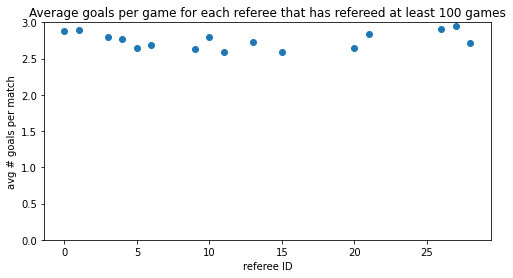

In [47]:
import numpy as np
import matplotlib.pyplot as plt
refs = games["referee"].unique()
ref_goals = np.zeros(len(refs))
ref_games = np.zeros(len(refs))

for game in games.itertuples():
    ref_goals[game.referee] += (game.home_club_goals + game.away_club_goals)
    ref_games[game.referee] += 1
    

over_100_games = np.where(ref_games>=100)
ref_games = ref_games[over_100_games]
ref_goals = ref_goals[over_100_games]
refs = refs[over_100_games]
ref_avg_goals = np.divide(ref_goals, ref_games)


fig = plt.figure(figsize=(8, 4))

plt.scatter(refs, ref_avg_goals)
plt.ylim(0, 3)
plt.title("Average goals per game for each referee that has refereed at least 100 games")
plt.xlabel("referee ID")
plt.ylabel("avg # goals per match")
# plt.savefig('avg-goals-referee')
np.average(ref_avg_goals)


### Distribution of goals scored

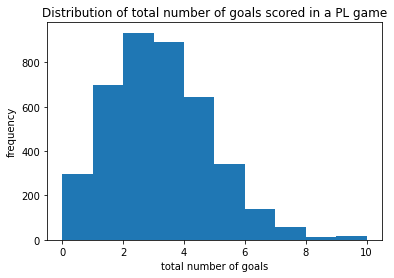

In [53]:
games["total_goals"] = games["home_club_goals"] + games["away_club_goals"]

plt.hist(games["total_goals"])
plt.xlabel("total number of goals")
plt.ylabel("frequency")
plt.title("Distribution of total number of goals scored in a PL game")
# plt.savefig("num-goals-distribution")


### At what points through the 90 minutes is a goal more likely to be scored?

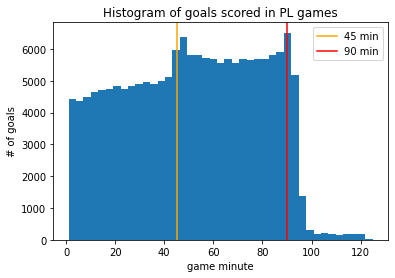

In [56]:
import matplotlib.pyplot as plt


goals = game_events[game_events["type"]=="Goals"] #get all goals
goals = goals.drop(columns=["player_in_id"])
goal_minutes = goals["minute"]

left_footed_goals = goals[goals["description"].str.contains("Head")]
right_footed_goals = goals[goals["description"].str.contains("Right")]
header_goals = goals[goals["description"].str.contains("Header")]

left_footed_goal_minutes = left_footed_goals["minute"]
right_footed_goal_minutes = right_footed_goals["minute"]
header_goal_minutes = header_goals["minute"]

plt.hist(goal_minutes, bins=41)
plt.axvline(x=45, color="orange", label="45 min")
plt.axvline(x=90, color="red", label="90 min")
plt.xlabel("game minute")
plt.ylabel("# of goals")
plt.title("Histogram of goals scored in PL games")
plt.legend()

## Training

### Initial training and results

In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score

# a loss and draw are treated the same
# binary classification
games["result"] = (games["home_club_goals"] > games["away_club_goals"]).astype("int")

# experiemted by removing each of the final 4 attributes
predictors = ['home_club_id', 'away_club_id', 'home_club_position', 'away_club_position', 'referee', 'matchday', 'day_code', 'attendance']

# not including the club positions decreases accuracy and precision each by 0.1
# predictors = ['home_club_id', 'away_club_id', 'attendance', 'referee', 'matchday']

X_train, X_test, y_train, y_test = train_test_split(games[predictors], games["result"], test_size=0.20, random_state=1)
rf = RandomForestClassifier(n_estimators=100, min_samples_split=10, random_state=1, max_features="sqrt")

rf.fit(X_train, y_train)
preds = rf.predict(X_test[predictors])

print(f"accuracy: {accuracy_score(y_test, preds)}")
print(f"precision: {precision_score(y_test, preds, average='weighted')}")



accuracy: 0.7128712871287128
precision: 0.7124863661034131


In [11]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir

  Using cached pip-23.0.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 21.3.1
    Uninstalling pip-21.3.1:
      Successfully uninstalled pip-21.3.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.6 MB/s eta 0:00:00:00:01
  Using cached wheel-0.38.4-py3-none-any.whl (36 kB)
  Attempting uninstall: wheel
    Found existing installation: wheel 0.34.2
    Uninstalling wheel-0.34.2:
      Successfully uninstalled wheel-0.34.2
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.3.0
    Uninstalling setuptools-59.3.0:
      Successfully uninstalled setuptools-59.3.0
  Using cached mxnet-1.9.1-py3-none-manylinux2014_x86_64.whl (49.1 MB)
  Using cached bokeh-2.0.1-py3-none-any.whl
  Attempting uninstall: bokeh
    Found existing installation: bokeh 2.4.2
    Uninstalling bokeh-2.4.2:
      Successfully uninstalled bokeh-2.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 225.2 MB/s eta 0:00:00
 

### Experimenting with models produced by AutoGluon

In [ ]:
from autogluon.tabular import TabularPredictor
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# now a 3 class classifier (draw and loss are distinct classes)
conditions = [games.home_club_goals.eq(games.away_club_goals), games.home_club_goals.gt(games.away_club_goals), games.home_club_goals.lt(games.away_club_goals)]
choices = [0, 1, -1]
games["result"] = np.select(conditions, choices)

predictors = ['home_club_id', 'away_club_id', 'home_club_position', 'away_club_position', 'attendance', 'referee', 'matchday', 'day_code']
# this set of predictors includes number of clean sheets kept in previous 5 games for each club as well
# predictors = ['home_club_id', 'away_club_id', 'home_club_position', 'away_club_position', 'attendance', 'referee', 'matchday', 'day_code', 'home_clean_sheets_prev_5_games', 'away_clean_sheets_prev_5_games']

X_train, X_test, y_train, y_test = train_test_split(games[predictors], games["result"], test_size=0.20, random_state=1)

# AutoGluon requires the data to be in this format
train = X_train
train['result'] = y_train
test = X_test

predictor = TabularPredictor(label="result", eval_metric="log_loss").fit(train, time_limit=600, presets="best_quality")

In [14]:
# predictor = TabularPredictor.load("AutogluonModels/ag-20230306_124106/")
predictor.fit_summary()
print(f"Best performing model is {predictor.get_model_best()}")

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       WeightedEnsemble_L2  -0.877979       0.298293  120.993204                0.001451           1.911580            2       True         14
1       WeightedEnsemble_L3  -0.880005       2.315493  498.632060                0.002036           1.813042            3       True         26
2           CatBoost_BAG_L2  -0.881640       1.566828  281.795737                0.024179         100.234946            2       True         20
3           CatBoost_BAG_L1  -0.885670       0.013189   19.063168                0.013189          19.063168            1       True          8
4     NeuralNetTorch_BAG_L1  -0.885826       0.109207   43.391422                0.109207          43.391422            1       True         12
5     NeuralNetTorch_BAG_L2  -0.886771       1.681186  221.346560         

In [18]:
preds = predictor.predict(test)

print(accuracy_score(y_test, preds))
print(precision_score(y_test, preds, average="weighted"))


AttributeError: Custom classes or functions exported with your `Learner` not available in namespace.\Re-declare/import before loading:
	Can't get attribute '_unpickle_block' on <module 'pandas._libs.internals' from '/usr/local/lib/python3.8/dist-packages/pandas/_libs/internals.cpython-38-x86_64-linux-gnu.so'>

### Refinement

In [231]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score


# including custom attributes clean sheets kept and the average player valuation 
predictors = ['home_club_id', 'away_club_id', 'home_club_position', 'away_club_position', 'referee', "matchday", 'day_code', 'attendance', 'home_avg_player_valuation', 'away_avg_player_valuation', 'home_clean_sheets_prev_5_games', 'away_clean_sheets_prev_5_games']
X_train, X_test, y_train, y_test = train_test_split(games[predictors], games["result"], test_size=0.20, random_state=1)

# hyperparameter tuning
estimators = [100, 1000, 5000]
min_samples_splits = [10, 20, 30]
max_features = ["sqrt", "log2"]

for num_estimators in estimators:
    for min_samples_split in min_samples_splits:
        for feature_type in max_features:
            
            print(f"===Hyperparameters used n_estimators: {num_estimators}, min_samples_split: {min_samples_split}, max_features: {feature_type}===")
            rf = RandomForestClassifier(n_estimators=num_estimators, min_samples_split=min_samples_split, random_state=1, max_features=feature_type)

            rf.fit(X_train, y_train)
            preds = rf.predict(X_test[predictors])

            print(f"Accuracy: {accuracy_score(y_test, preds):.3f}")
            print(f"Precision: {precision_score(y_test, preds, average='weighted'):.3f}")
            

===Hyperparameters used n_estimators: 100, min_samples_split: 10, max_features: sqrt===
Accuracy: 0.607
Precision: 0.583
===Hyperparameters used n_estimators: 100, min_samples_split: 10, max_features: log2===
Accuracy: 0.607
Precision: 0.583
===Hyperparameters used n_estimators: 100, min_samples_split: 20, max_features: sqrt===
Accuracy: 0.595
Precision: 0.550
===Hyperparameters used n_estimators: 100, min_samples_split: 20, max_features: log2===
Accuracy: 0.595
Precision: 0.550
===Hyperparameters used n_estimators: 100, min_samples_split: 30, max_features: sqrt===
Accuracy: 0.601
Precision: 0.558
===Hyperparameters used n_estimators: 100, min_samples_split: 30, max_features: log2===
Accuracy: 0.601
Precision: 0.558
===Hyperparameters used n_estimators: 1000, min_samples_split: 10, max_features: sqrt===
Accuracy: 0.602
Precision: 0.575
===Hyperparameters used n_estimators: 1000, min_samples_split: 10, max_features: log2===
Accuracy: 0.602
Precision: 0.575
===Hyperparameters used n_esti

,home_club_id,away_club_id,home_club_position,away_club_position,referee,matchday,day_code,attendance,home_avg_player_valuation,away_avg_player_valuation,home_clean_sheets_prev_5_games,away_clean_sheets_prev_5_games
11601,379,985,8,4,19,24,6,34499,6000000.0,26150000.0,1,1
40406,379,631,16,4,21,32,2,0,13640000.0,33250000.0,0,1
34529,11,543,5,11,33,12,6,60030,34790000.0,12960000.0,0,0
56538,180,543,20,15,12,23,5,0,14220000.0,16580000.0,0,2
17515,631,1010,15,7,0,18,5,41620,31690000.0,3480000.0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
40443,31,989,1,18,27,29,5,53323,64540000.0,15320000.0,1,0
50933,873,399,14,16,8,34,0,25357,13080000.0,15890000.0,1,1
51130,1132,1148,18,12,14,10,5,18821,9380000.0,8250000.0,1,0
23063,2288,512,18,11,22,34,5,20566,6710000.0,8770000.0,0,0


In [26]:
from sklearn.ensemble import RandomForestClassifier

# Predicting outcome of Liverpool v Manchester United (05/03/2023)
rf = RandomForestClassifier(n_estimators=5000, min_samples_split=10, random_state=1, max_features="sqrt")
predictors = ['home_club_id', 'away_club_id', 'home_club_position', 'away_club_position', 'referee', "matchday", 'day_code', 'attendance', 'home_avg_player_valuation', 'away_avg_player_valuation', 'home_clean_sheets_prev_5_games', 'away_clean_sheets_prev_5_games']
X_train, X_test, y_train, y_test = train_test_split(games[predictors], games["result"], test_size=0.20, random_state=1)

rf.fit(X_train, y_train)
today_test = pd.DataFrame(data=[[31, 985, 6, 3, 1, 26, 6, 52000, 41600000, 28900000, 4, 2]], columns=predictors)
preds = rf.predict(today_test)
preds


array([1])